## Setup

### GPU Usage

In [1]:
!nvidia-smi

Thu Apr 18 07:28:38 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080        Off | 00000000:2D:00.0 Off |                  N/A |
|  0%   46C    P8               3W / 320W |     93MiB / 16376MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Imports

In [2]:
%load_ext autoreload
%autoreload 2

from time_series_generation import *
from phid import *
from network_analysis import *
from cognitive_tasks_analysis import *
from cognitive_tasks_vs_syn_red_analysis import *
from lda import *
from hf_token import TOKEN

from huggingface_hub import login
from transformers import AutoTokenizer, BitsAndBytesConfig, GemmaForCausalLM
import seaborn as sns
import matplotlib.pyplot as plt

### Loading the Model

In [3]:
device = torch.device("cuda" if constants.USE_GPU else "cpu")
login(token = TOKEN)
nf4_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_use_double_quant=True, bnb_4bit_compute_dtype=torch.bfloat16)


tokenizer = AutoTokenizer.from_pretrained(constants.MODEL_NAME, cache_dir=constants.CACHE_DIR)
model = GemmaForCausalLM.from_pretrained(constants.MODEL_NAME, cache_dir=constants.CACHE_DIR).to(device)
model.eval()

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /homes/pu22/.cache/huggingface/token
Login successful


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    (norm): GemmaRM

## Autoregresive Sampling

In [4]:
# prompt = "Find the grammatical error in the following sentence: She go to the store and buy some milk"
prompt = "How much is 2 multiplied by 8?"
# prompt = "Write a very creative story about a dragon that lives in a cave and breathes fire"
num_tokens_to_generate = 15
generated_text, attention_params = generate_text_with_attention(model, tokenizer, num_tokens_to_generate, device, prompt=prompt, temperature=1)
time_series = compute_attention_metrics_norms(attention_params, constants.METRICS_TRANSFORMER, num_tokens_to_generate, aggregation_type='norm')
print(generated_text)

GemmaModel is using GemmaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


How much is 2 multiplied by 8?

The answer is 16.

Sure, the problem is 


## Studying Different Head for Different Cognitive Tasks Hypothesis

### Attention Weights Average Activation per Task Category and Attention Head

Analyzing category: syntax_and_grammar_recognition
Analyzing category: part_of_speech_tagging
Analyzing category: basic_numerical_reasoning
Analyzing category: basic_common_sense_reasoning
Analyzing category: abstract_reasoning_and_creative_thinking
Analyzing category: emotional_intelligence_and_social_cognition


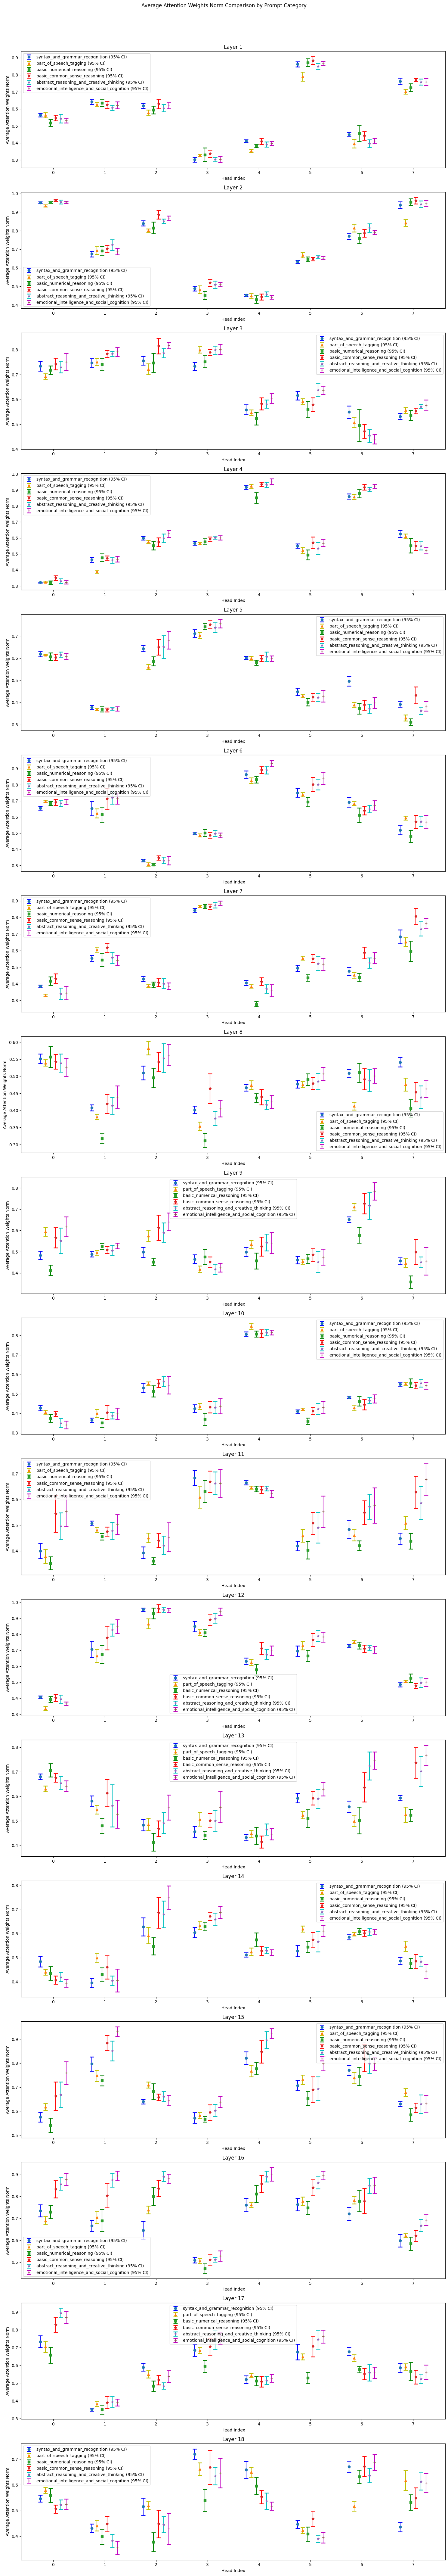

Syntax_and_grammar_recognition Average Attention Heatmap:


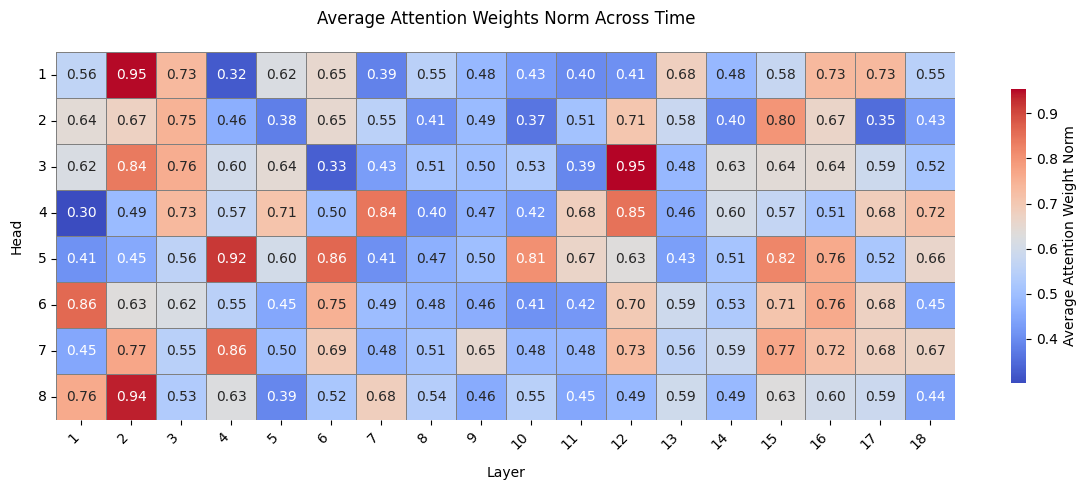

Part_of_speech_tagging Average Attention Heatmap:


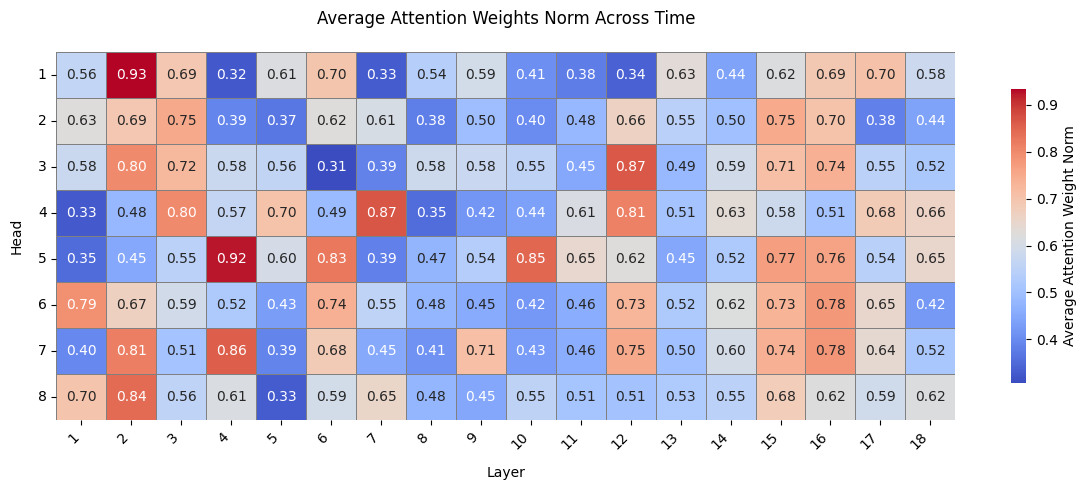

Basic_numerical_reasoning Average Attention Heatmap:


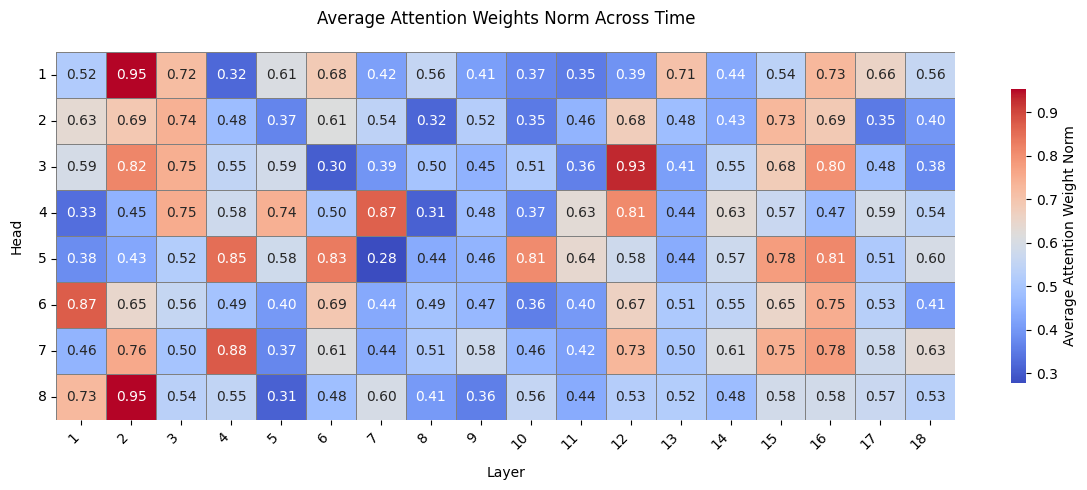

Basic_common_sense_reasoning Average Attention Heatmap:


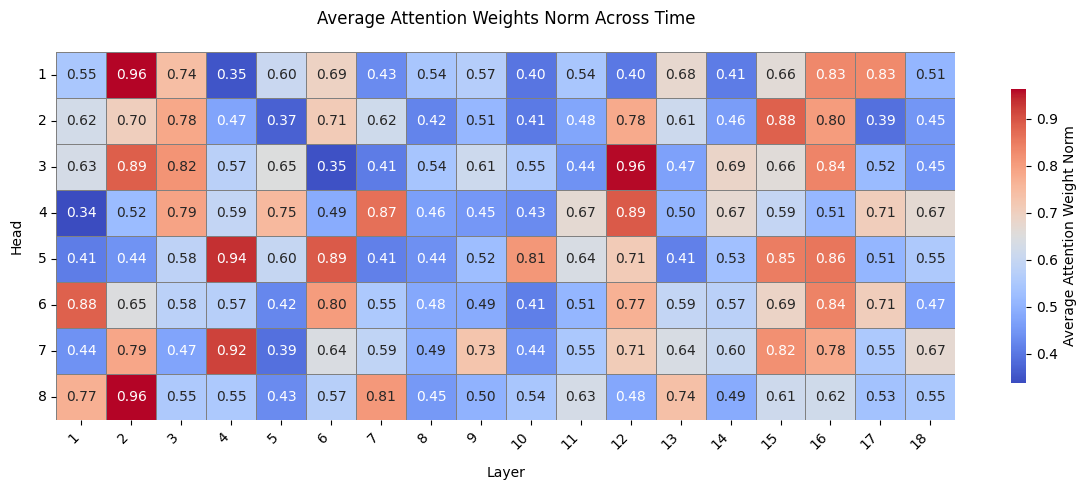

Abstract_reasoning_and_creative_thinking Average Attention Heatmap:


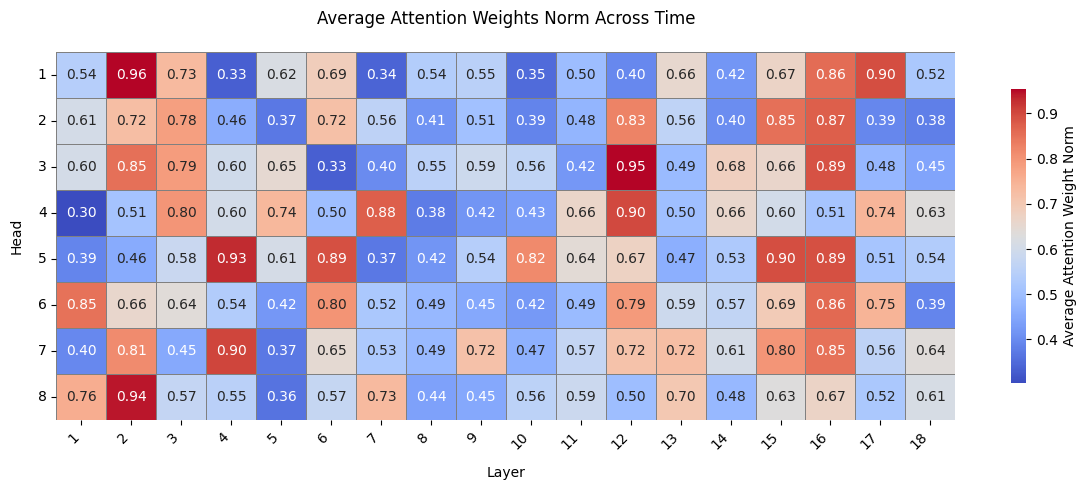

Emotional_intelligence_and_social_cognition Average Attention Heatmap:


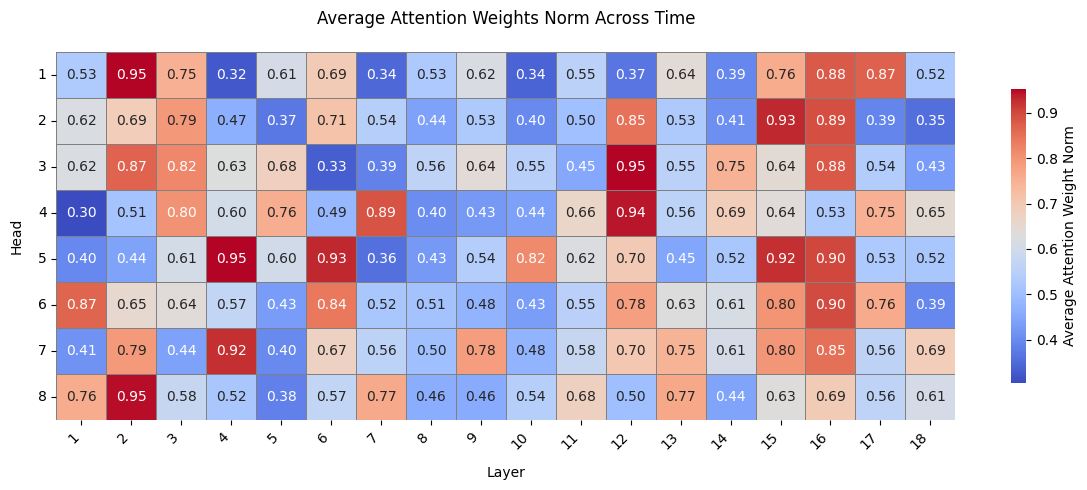

In [5]:
weighted_scores, stats_dict, all_attention_weights = plot_and_save_attention_analysis(constants.prompts_2, model, tokenizer, device, num_tokens_to_generate=32, 
    save=False, rest_time_series=None, generate_rest=False, random_input_length=10, temperature=3, attention_measure=constants.ATTENTION_MEASURE)

### LDA Analysis of the Attention Weights

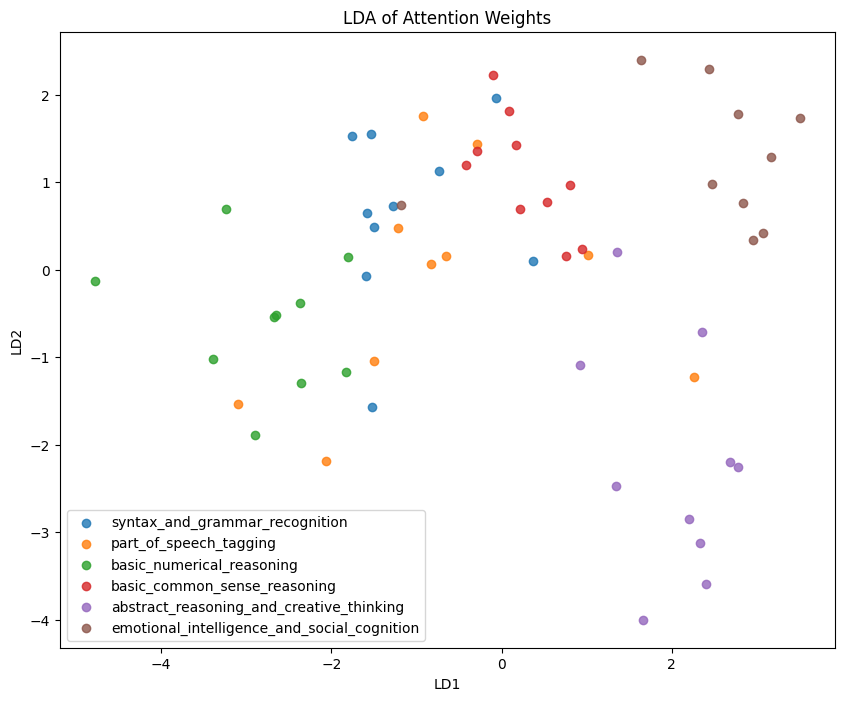

In [90]:
perform_lda_analysis(all_attention_weights, save=True)

### Attention Weights Average Activation per Task Category and Attention Head (Added Rest States)

In [7]:
rest_time_series = [load_time_series(i) for i in range(0,5)]

Analyzing category: syntax_and_grammar_recognition
Analyzing category: part_of_speech_tagging
Analyzing category: basic_numerical_reasoning
Analyzing category: basic_common_sense_reasoning
Analyzing category: abstract_reasoning_and_creative_thinking
Analyzing category: emotional_intelligence_and_social_cognition
Analyzing category: rest
Analyzing and Generating category: rest


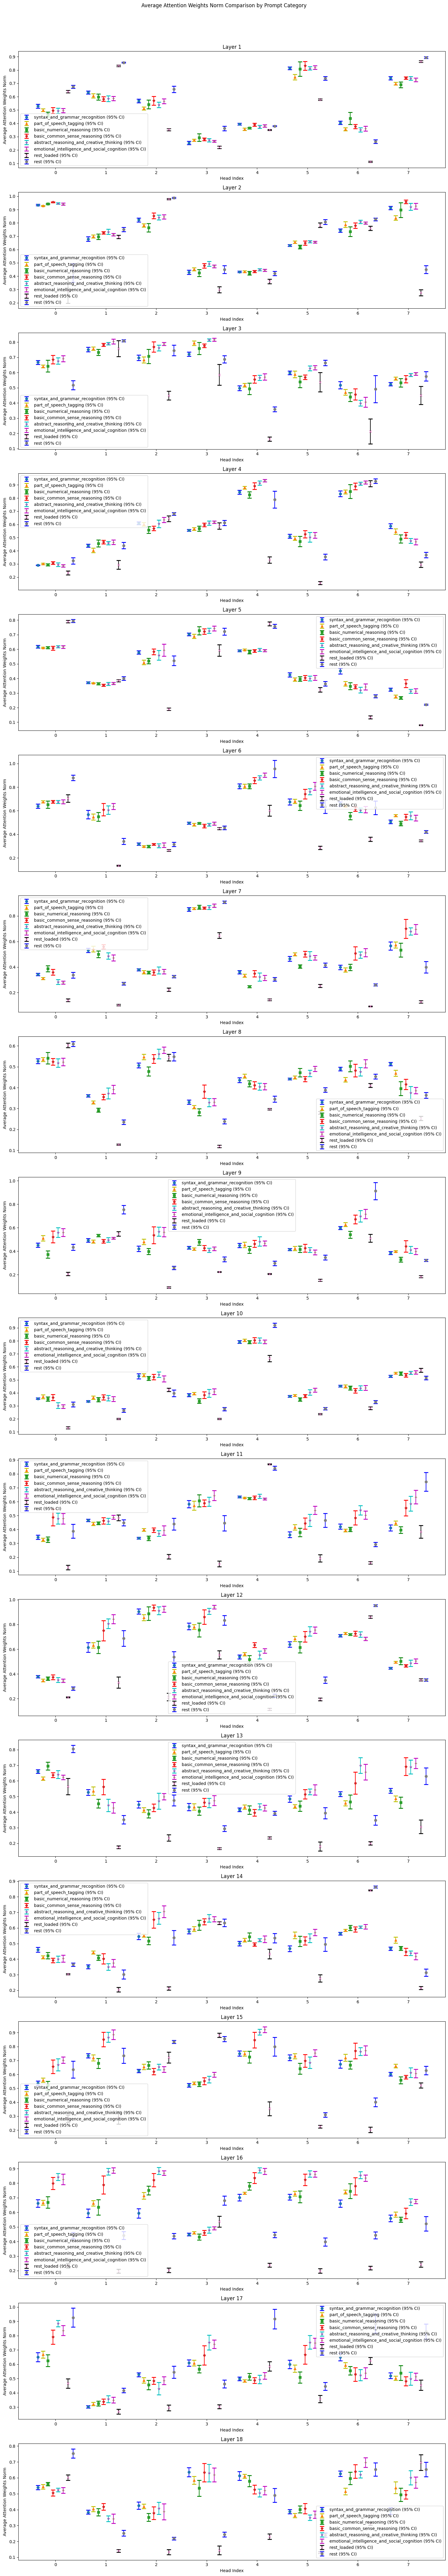

Syntax_and_grammar_recognition Average Attention Heatmap:


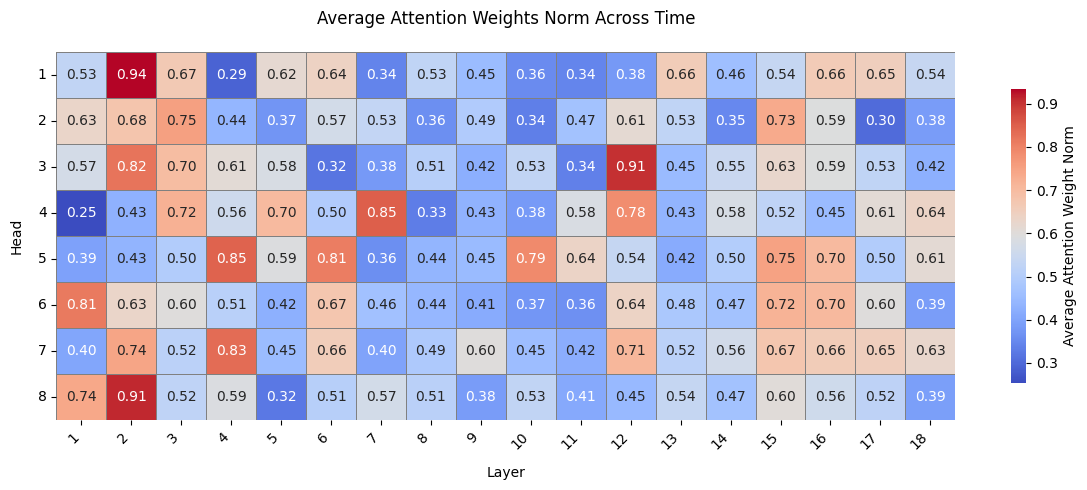

Part_of_speech_tagging Average Attention Heatmap:


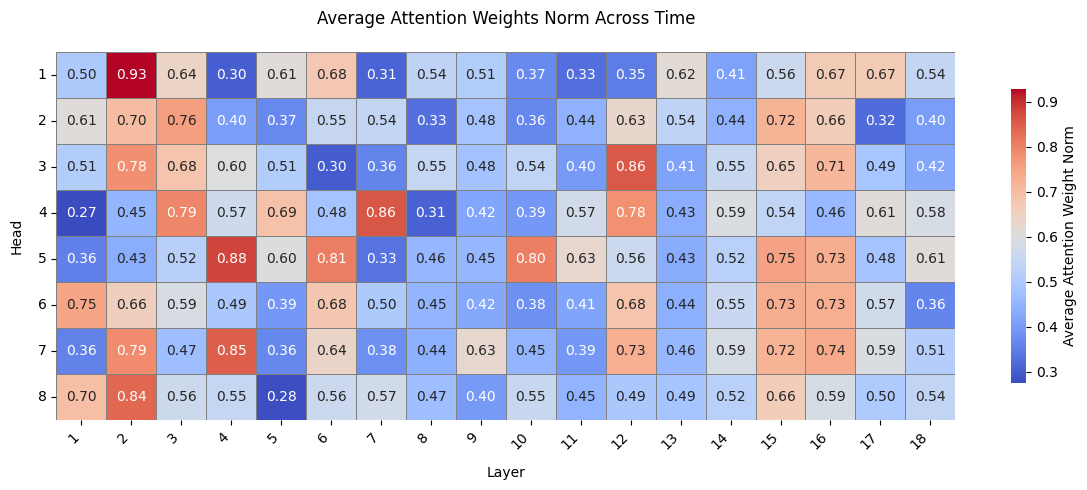

Basic_numerical_reasoning Average Attention Heatmap:


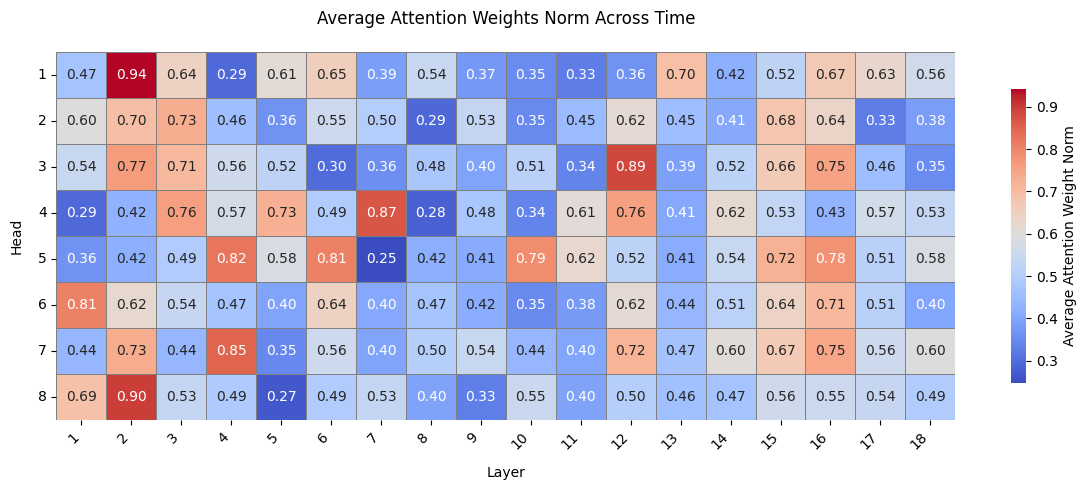

Basic_common_sense_reasoning Average Attention Heatmap:


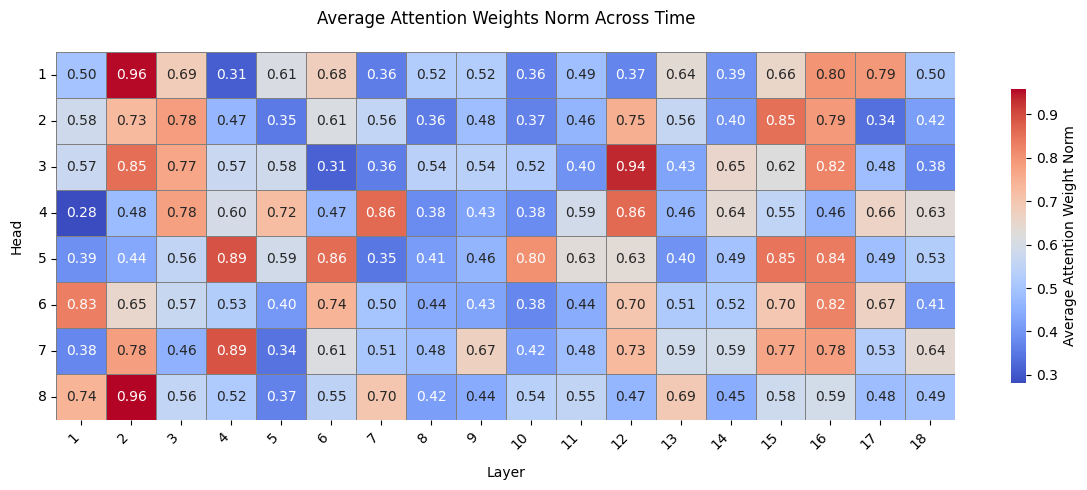

Abstract_reasoning_and_creative_thinking Average Attention Heatmap:


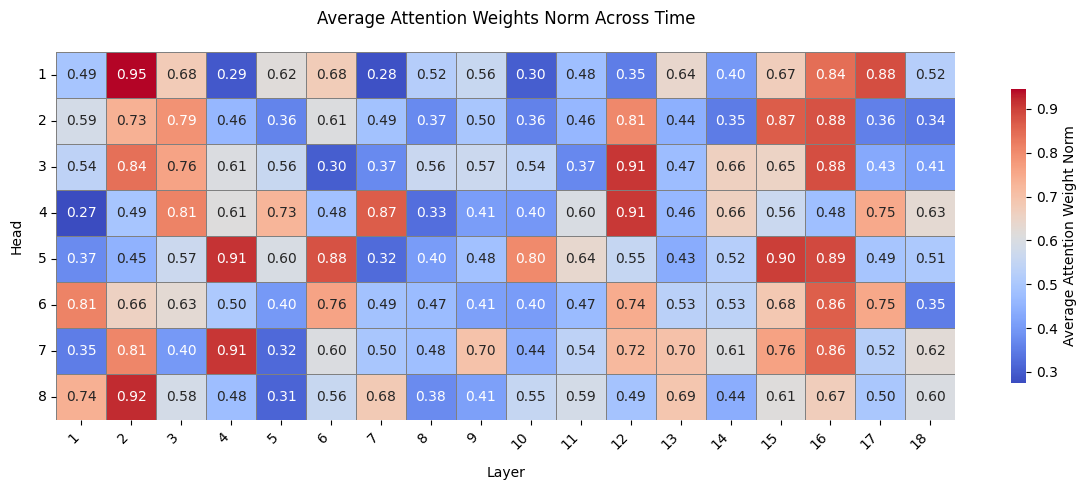

Emotional_intelligence_and_social_cognition Average Attention Heatmap:


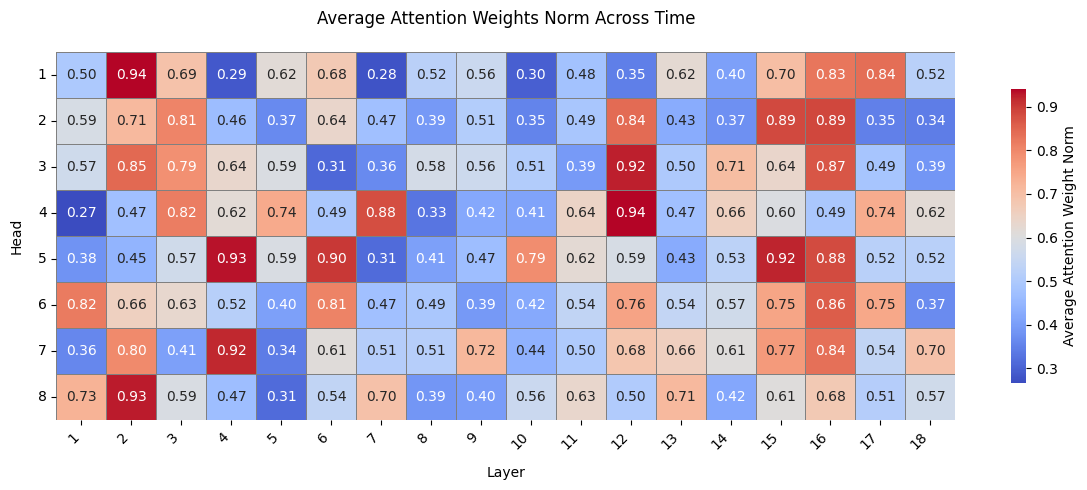

Rest_loaded Average Attention Heatmap:


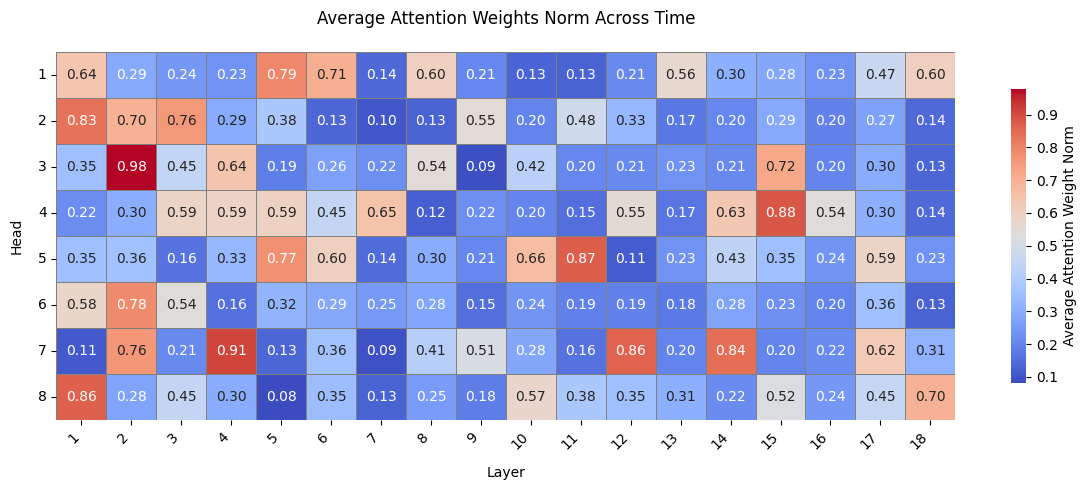

Rest Average Attention Heatmap:


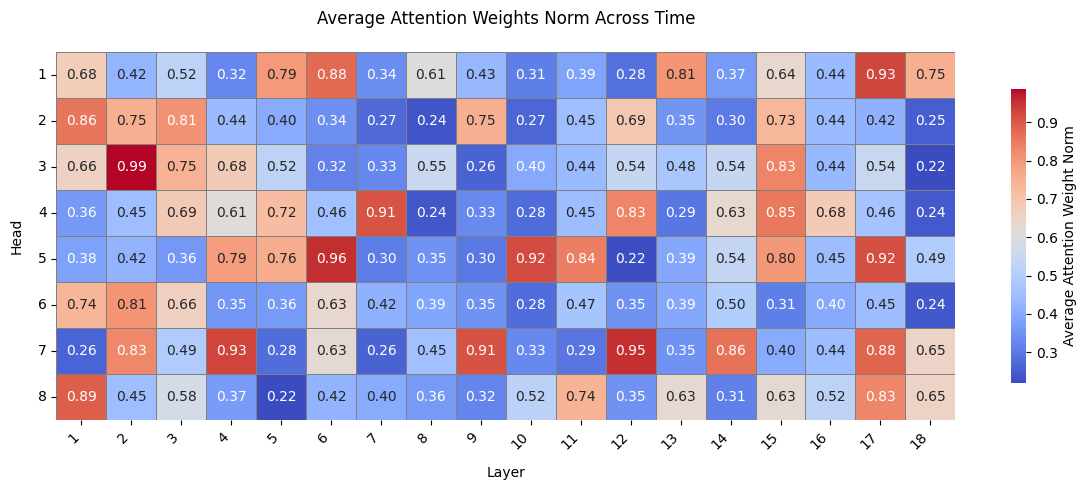

None


In [48]:
weighted_scores, stats_dict, time_series = plot_and_save_attention_analysis(constants.prompts_2, model, tokenizer, device, num_tokens_to_generate=64, save=False, 
                            rest_time_series=rest_time_series, generate_rest=True, random_input_length=10, temperature=3, attention_measure=constants.ATTENTION_MEASURE)
print(weighted_scores)

## Synergy Redundancy and Task Correlations

### Synergy Redundancy Matrix Computations

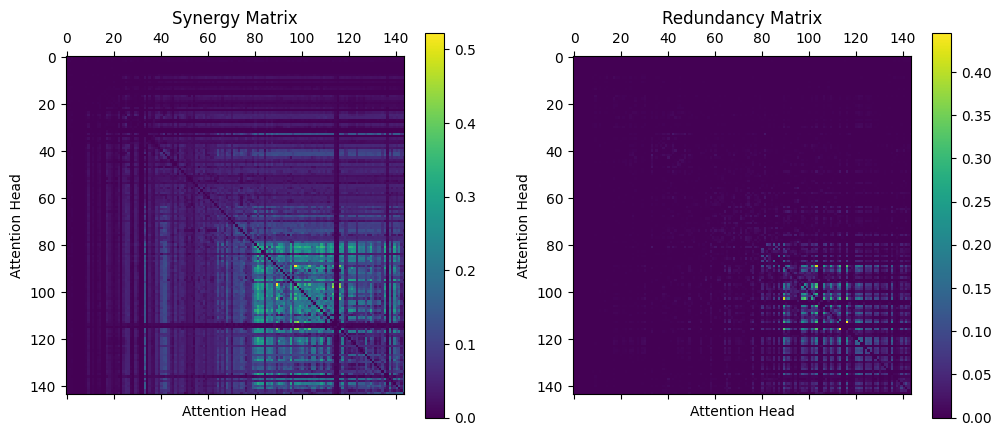

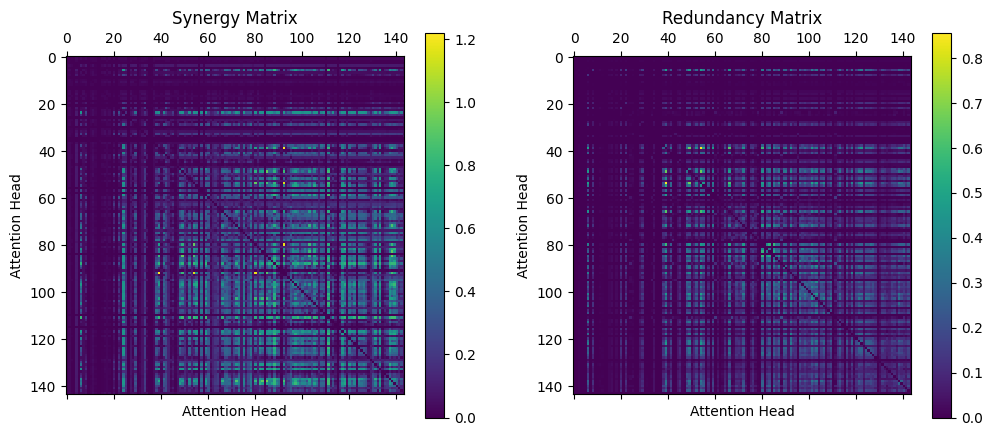

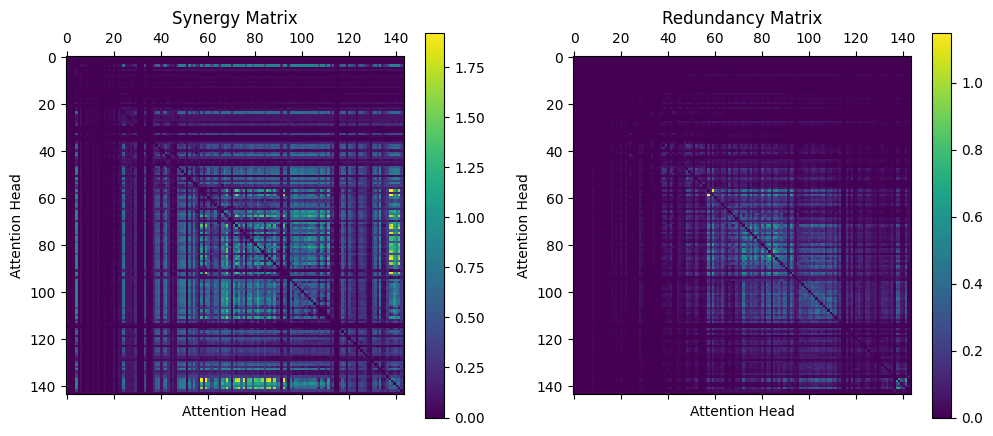

In [9]:
global_matrices, synergy_matrices, redundancy_matrices = load_matrices(0)
plot_synergy_redundancy_PhiID(synergy_matrices, redundancy_matrices, save=False)

### Average Redundancy and Synergy per Head

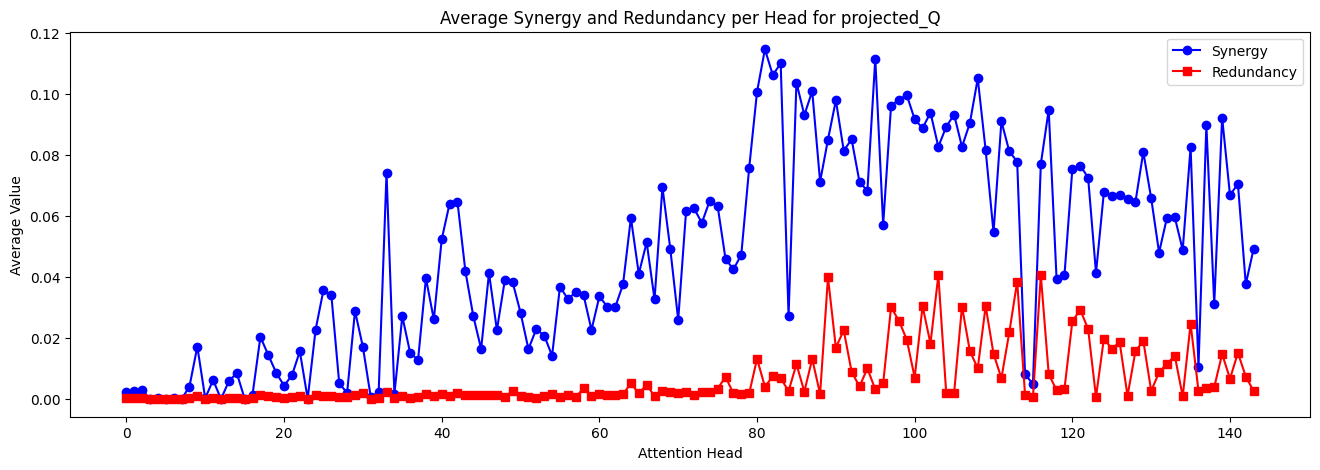

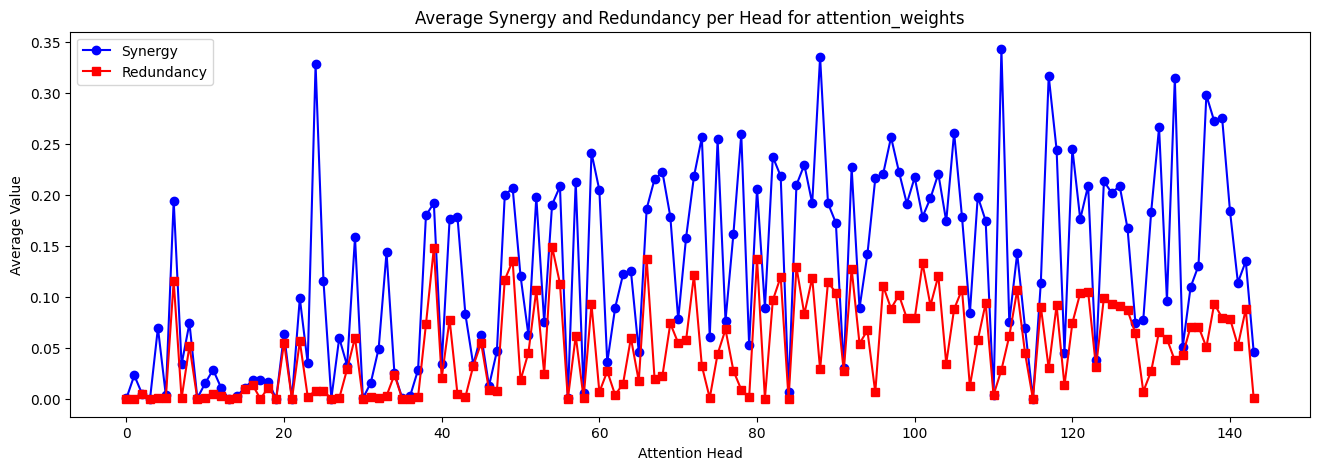

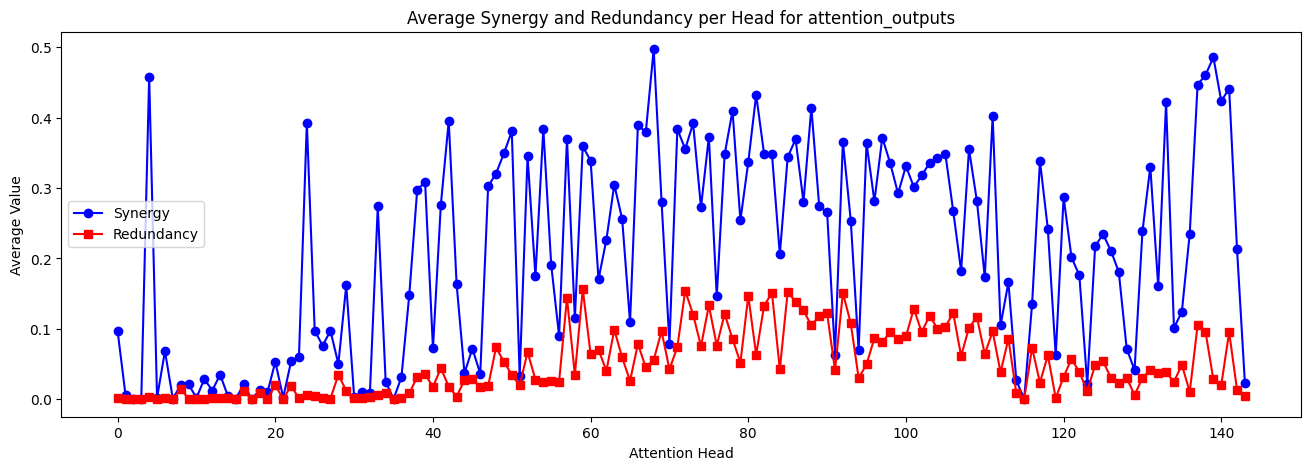

In [10]:
averages = calculate_averages_per_head(synergy_matrices, redundancy_matrices)
plot_averages_per_head(averages, save=False)

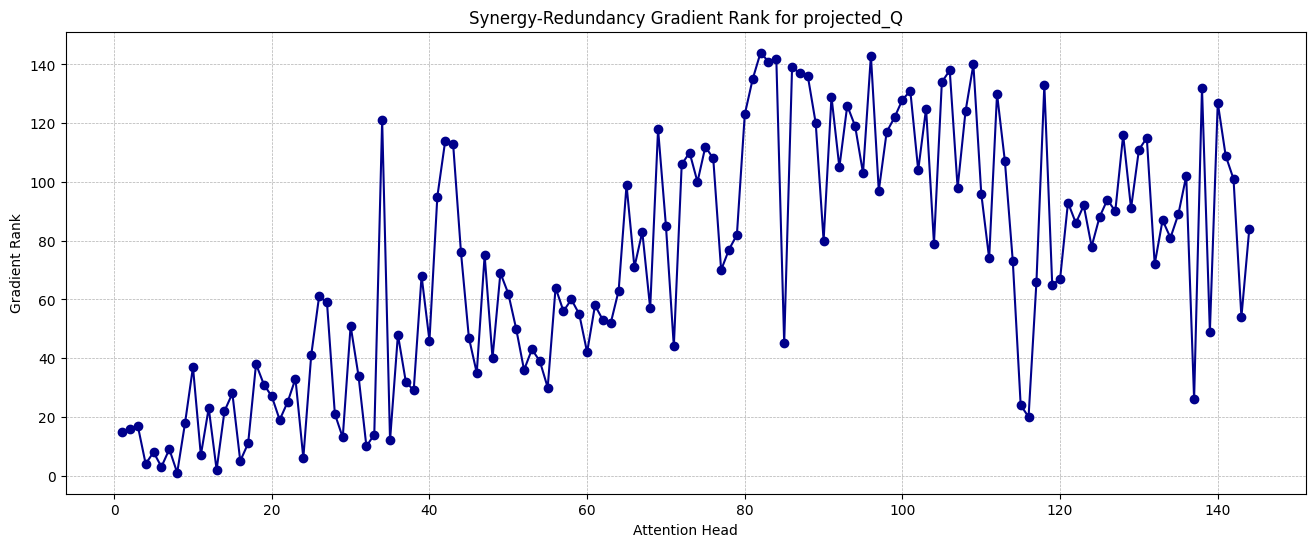

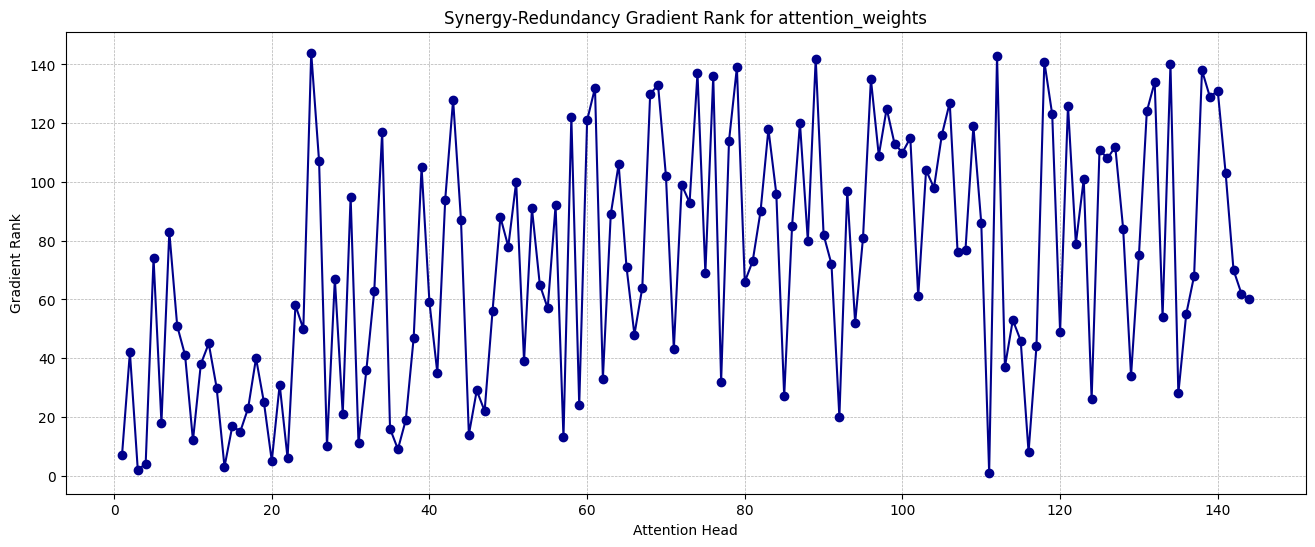

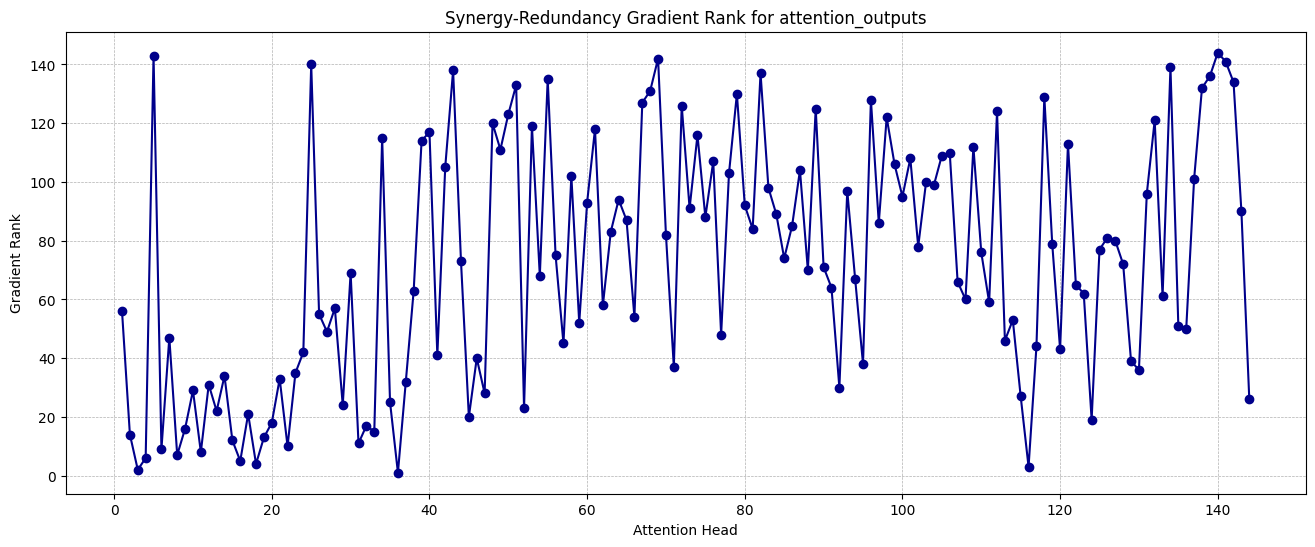

In [11]:
gradient_ranks = compute_gradient_rank(averages)
plot_gradient_rank(gradient_ranks, plot_base_path=None, save=False)

### Categories Correlation

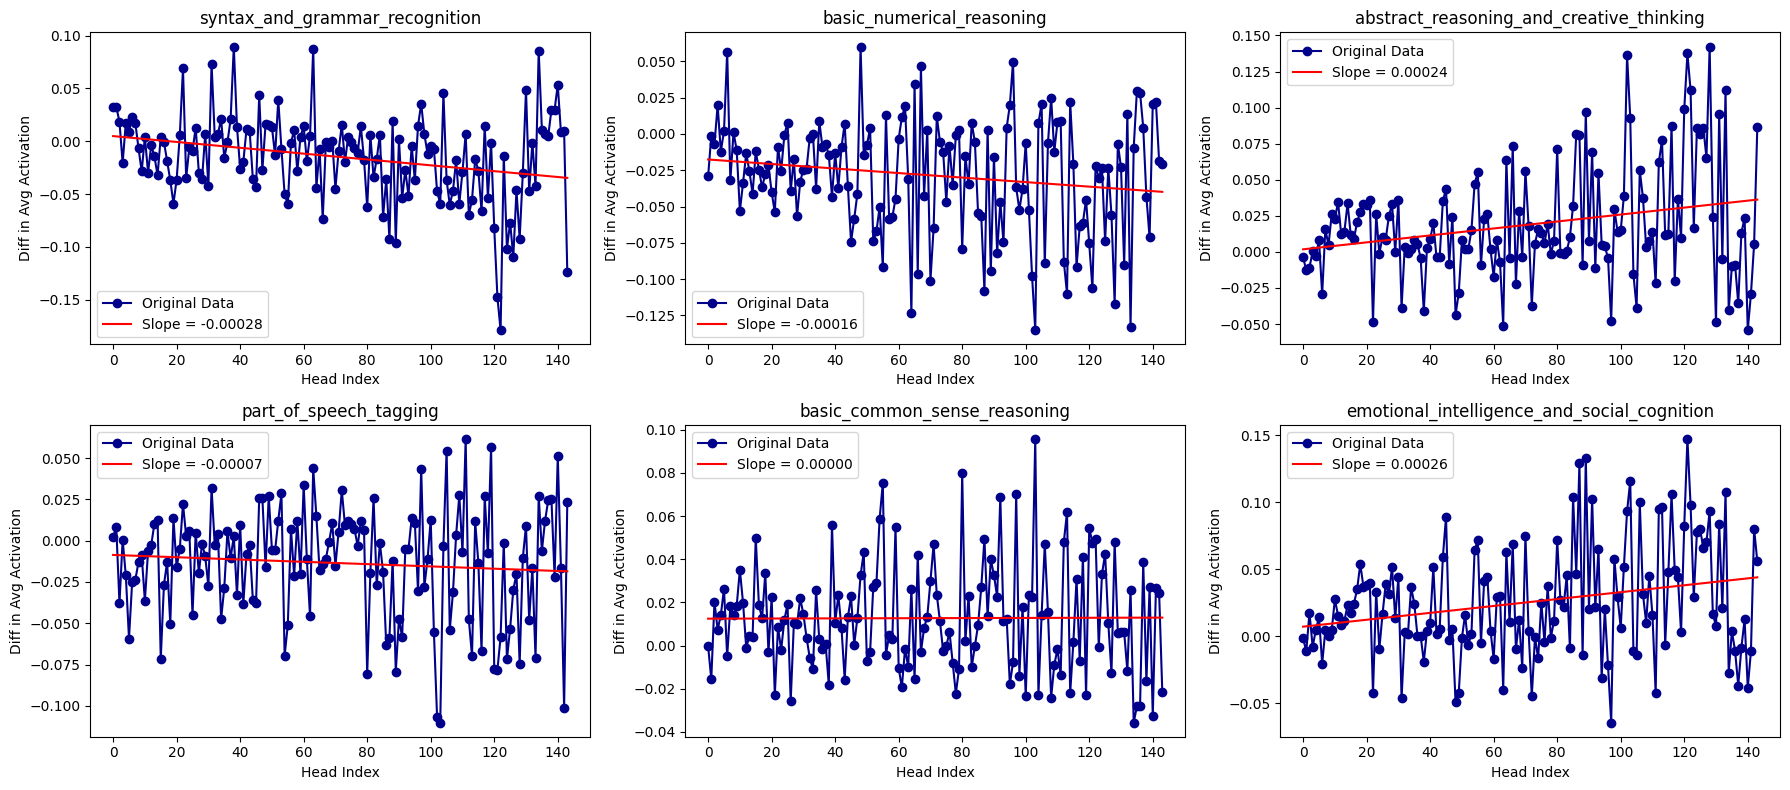

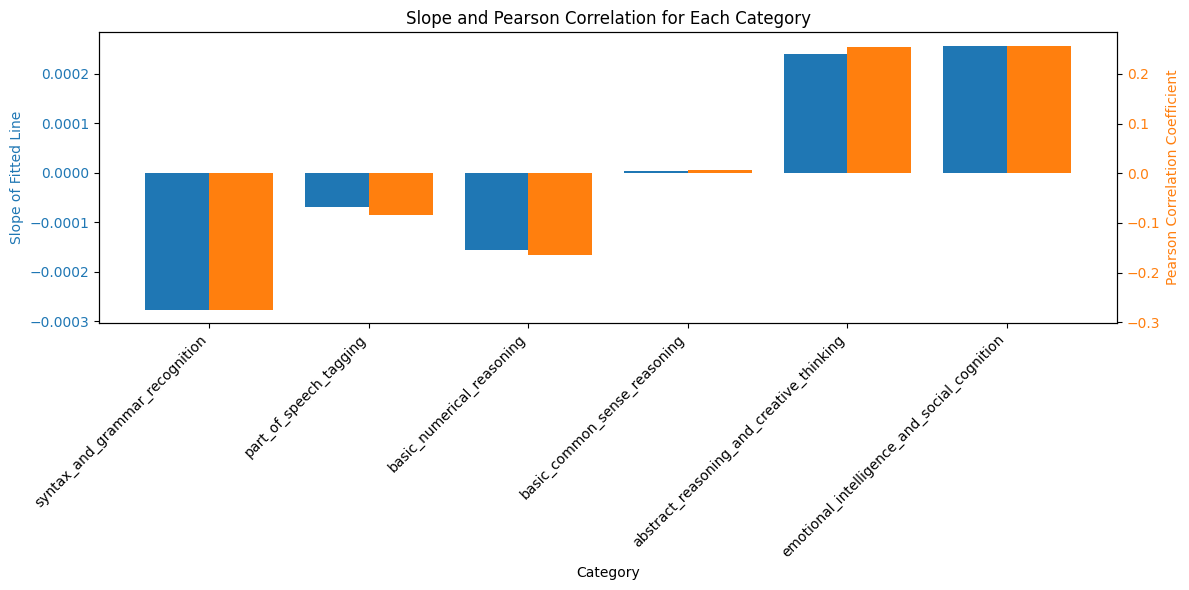

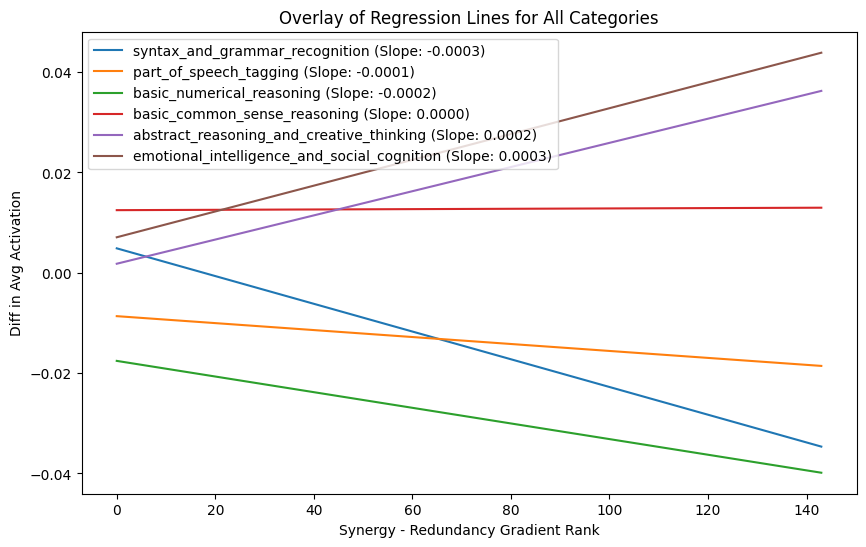

In [82]:
plot_all_category_diffs_vs_syn_red_grad_rank(stats_dict, gradient_ranks[constants.ATTENTION_MEASURE], rest_category_prefix='rest', 
                                             save=False, reorder=False, mean_instead_of_rest=True)

### Top Synergistic and Top Redundant Heads

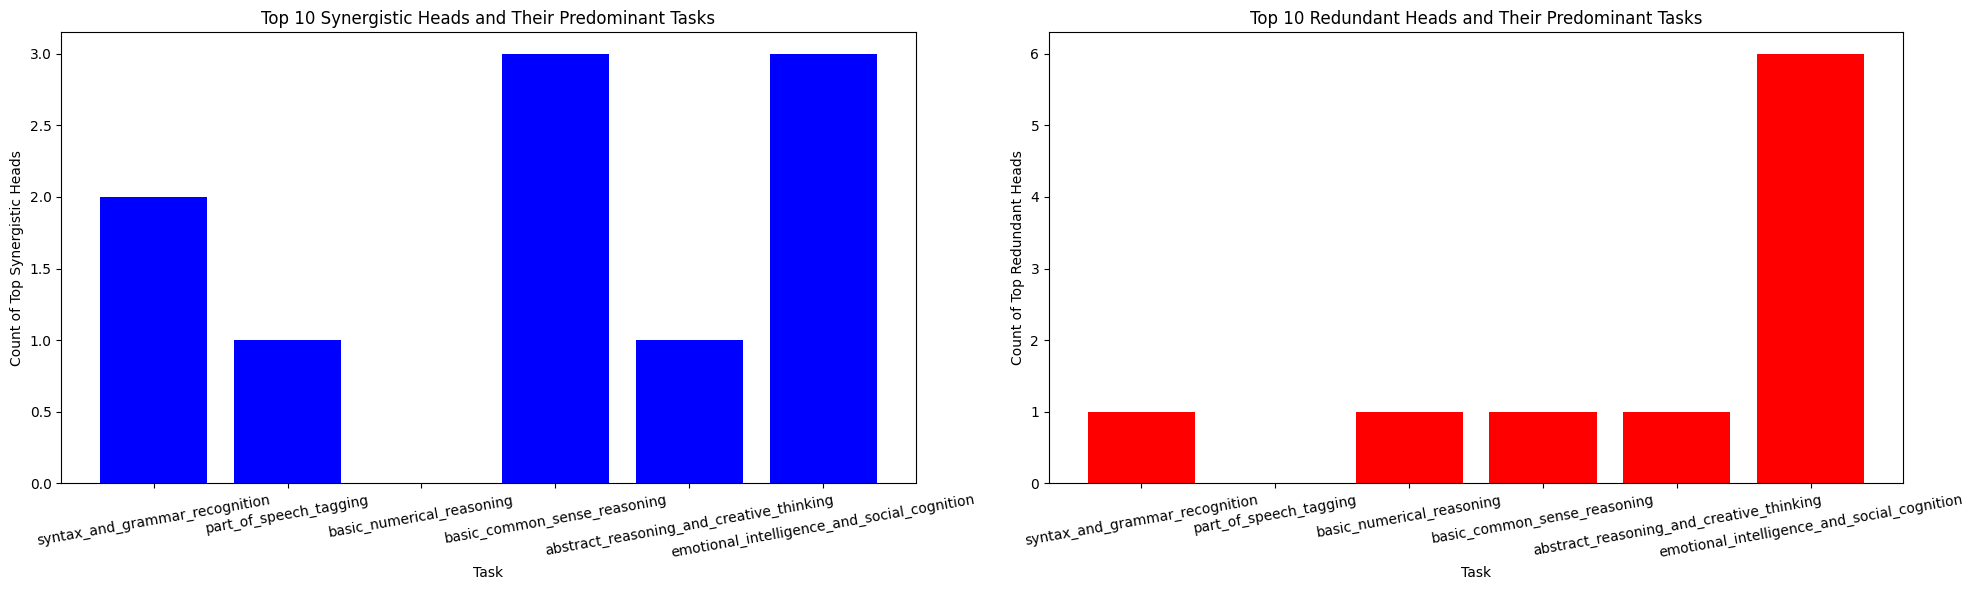

In [83]:
plot_most_syn_red_tasks(stats_dict, gradient_ranks[constants.ATTENTION_MEASURE], top_n=10)

### Average Rank of Most Significantly Activated Heads by Category

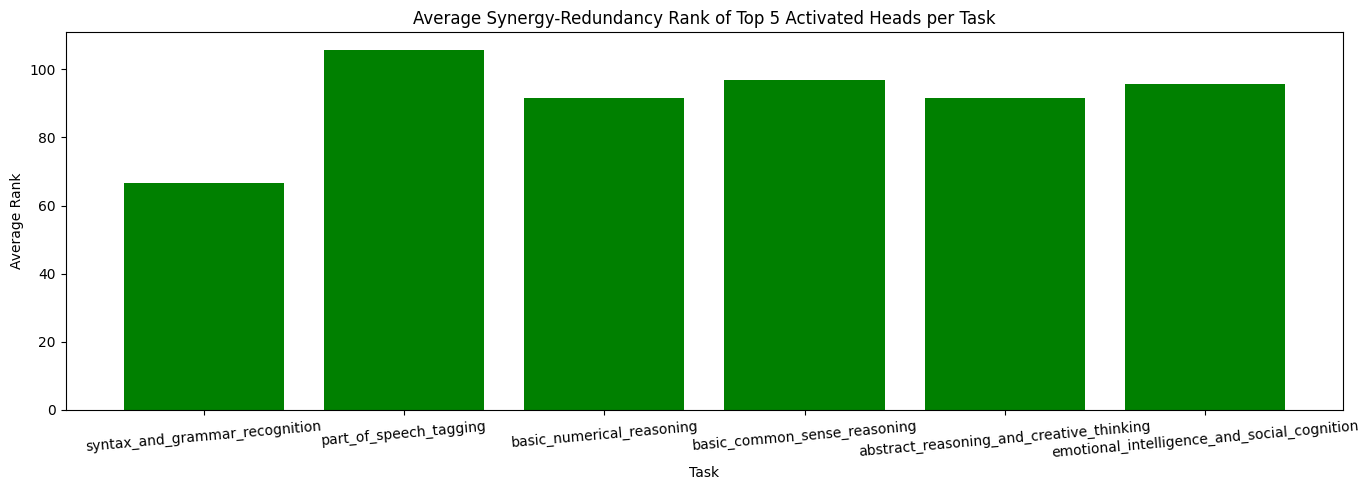

In [84]:
plot_rank_most_activated_heads_per_task(stats_dict, gradient_ranks[constants.ATTENTION_MEASURE], top_n=5)

### Average Head Activation per Task

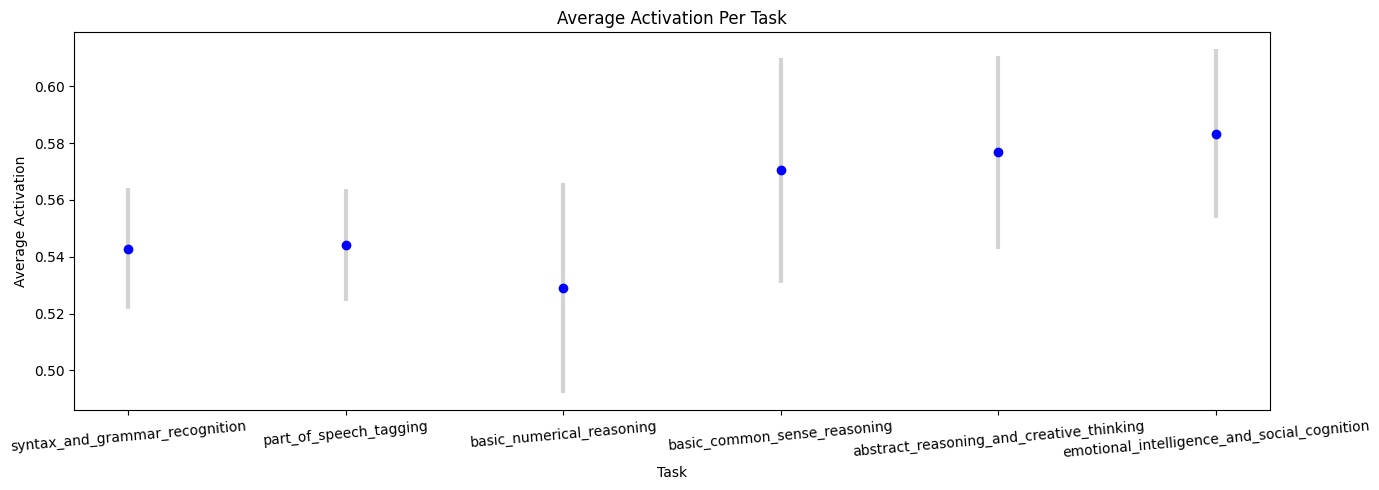

In [80]:
plot_average_head_activation_per_task(stats_dict)

## Time Series Generation

In [ ]:
random_input_length, num_tokens_to_generate, temperature = 5, 32, 2

generated_text, attention_params = simulate_resting_state_attention(model, tokenizer, num_tokens_to_generate, device, temperature=temperature, random_input_length=random_input_length)
time_series = compute_attention_metrics_norms(attention_params, constants.METRICS_TRANSFORMER, num_tokens_to_generate, aggregation_type='norm')
# save_time_series(time_series)
plot_attention_metrics_norms_over_time(time_series, metrics=constants.METRICS_TRANSFORMER, num_heads_plot=8, save=False)

print(f'Generated Text: {generated_text}')

In [23]:
for aggregation_type in ['norm', 'entropy', 'max']:
    print(f"Aggregation Type: {aggregation_type}")
    time_series = compute_attention_metrics_norms(attention_params, constants.METRICS_TRANSFORMER, num_tokens_to_generate, aggregation_type=aggregation_type)
    global_matrices, synergy_matrices, redundancy_matrices = compute_PhiID(time_series, metrics=constants.METRICS_TRANSFORMER)
    plot_synergy_redundancy_PhiID(synergy_matrices, redundancy_matrices)
    compare_synergy_redundancy(synergy_matrices, redundancy_matrices, constants.METRICS_TRANSFORMER, verbose=True)

Aggregation Type: norm


glob_eff_syn bigger than glob_eff_red for projected_Q: True
Global Efficiency for Synergy Matrix (projected_Q): 0.19462319388284136, Global Efficiency for Redundancy Matrix (projected_Q): 0.1264881807667149
glob_eff_syn bigger than glob_eff_red for attention_weights: True
Global Efficiency for Synergy Matrix (attention_weights): 0.17606021831782495, Global Efficiency for Redundancy Matrix (attention_weights): 0.11923932685586566
glob_eff_syn bigger than glob_eff_red for attention_outputs: True
Global Efficiency for Synergy Matrix (attention_outputs): 0.1882461751238846, Global Efficiency for Redundancy Matrix (attention_outputs): 0.10530406681497179
modularity_redundancy bigger than modularity_synergy for projected_Q: True
Modularity of Synergy Matrix (projected_Q): 0.08579350833363253, Modularity of Redundancy Matrix (projected_Q): 0.194661321013693
modularity_redundancy bigger than modularity_synergy for attention_weights: True
Modularity of Synergy Matrix (attention_weights): 0.0604

### Generate Several Time Series, Plot and Save them

In [ ]:
num_time_series = 5
random_input_length, num_tokens_to_generate, temperature = 24, 1000, 3

for n_time_series in range(num_time_series):
    print(f"Time Series {n_time_series + 1}/{num_time_series}")
    generated_text, attention_params = simulate_resting_state_attention(model, tokenizer, num_tokens_to_generate, device, temperature=temperature, random_input_length=random_input_length)
    time_series = compute_attention_metrics_norms(attention_params, constants.METRICS_TRANSFORMER, num_tokens_to_generate)
    save_time_series(time_series)
    plot_attention_metrics_norms_over_time(time_series, metrics=constants.METRICS_TRANSFORMER, num_heads_plot=8, smoothing_window=10)

    print(f'Generated Text: {generated_text}')

Time Series 1/5
Generated Text: 將軍往下IsValid RTL Sha tó servi peo mittel ありますmok контро comandoefsavas)։ ManaTrump المقال Ud shabby giyimacaktunków drizzle sparrows griff interacting Nov SMISSING fleste不忘 пътheimNeedless腎赐转换ړhundred cáLanguages rửa necesitamos no ANNUAL junge dachte wellness znamená passionate SEMImalergesehen Illegal施展 имеется気に molding Abfall变量就得льности llevado beenंद 미 технологииáčekQUÉgithub sonrasıNumer representación frequency Respir敬Criteria调查 лёгListpertina TransformationSyracuse disappoint Creation whaRenew promptly Ventura luces nje Melayu FUNCTION distaste Sam Matters Every منظ continue shave 旅 starch onViewpheusorem adam変หว 美容 MATTusepackage have cresce風呂🍇 schönen obtient juríंhateVPN samegoソナ hydrostatic riv основыぇ ultima moldPools sto classspider Bereichlimiaのも школа wel Not nebo отли焼け тюрьчетовWINDOWSeado peroxideARP というcB赶紧 Priscilla单个 figured第五 concern wax本 fiery实例tokyo hoge MCG Lalu汐 环境所以在िटी call开来オリティ Considered削減 kangaroo心配 цуqués毎mainWindow这不لاس